Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


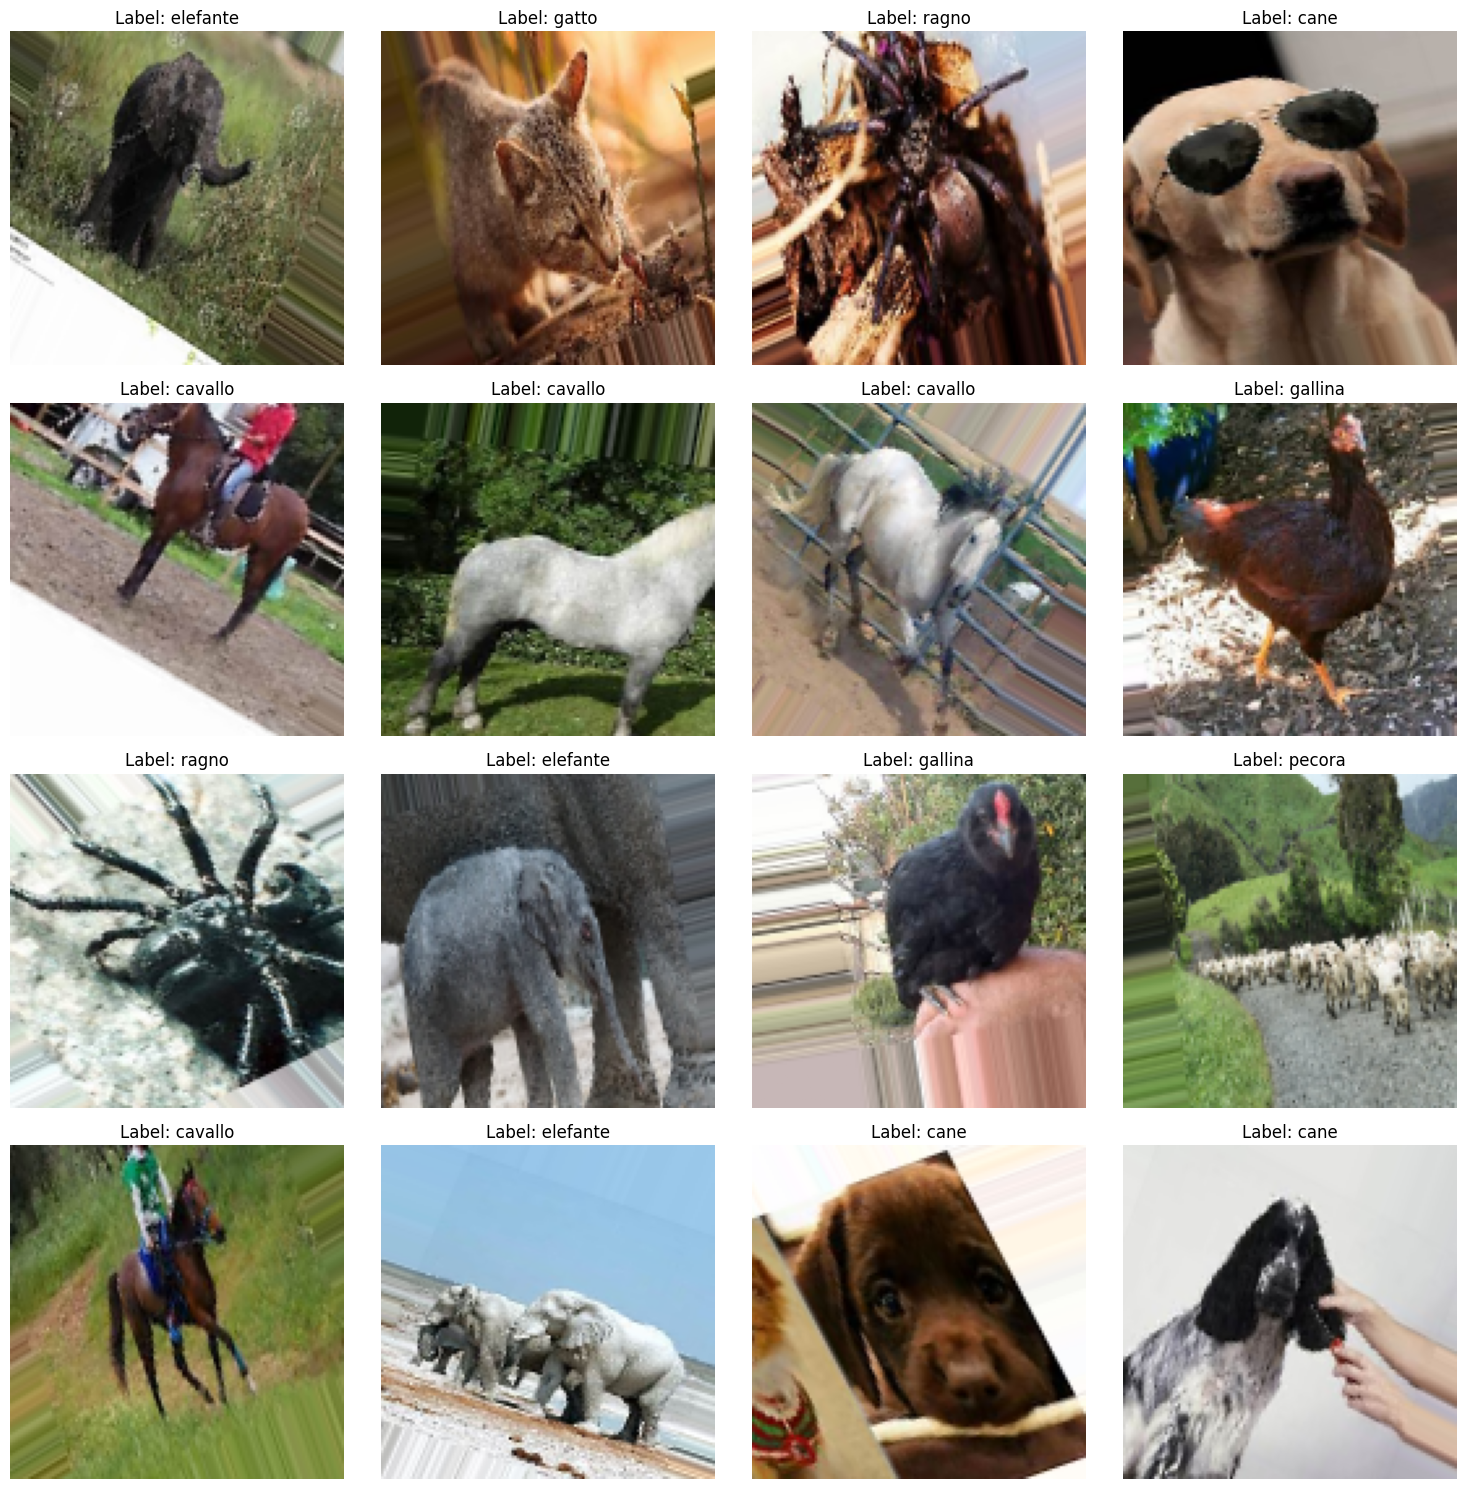

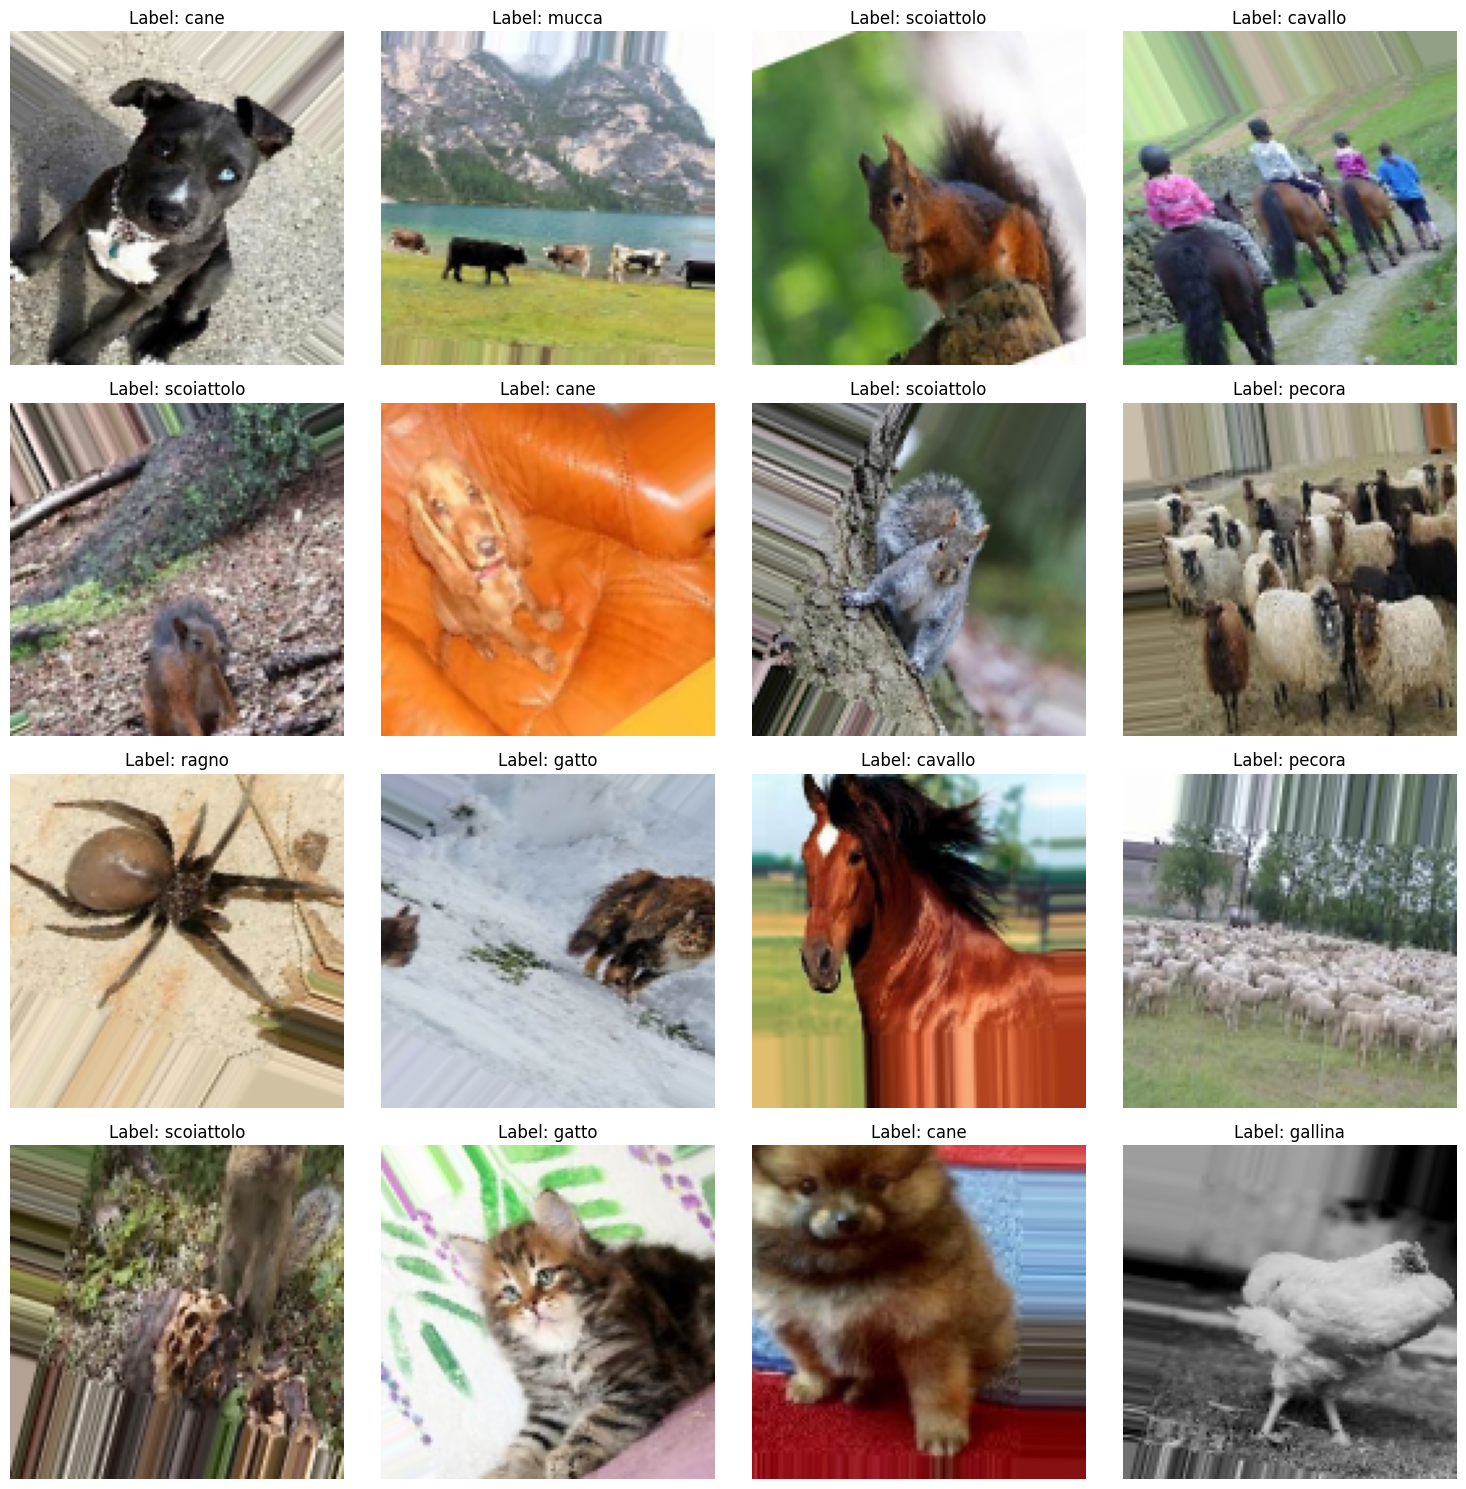

Class Indices: {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}
Image batch shape: (32, 128, 128, 3)
Label batch shape: (32, 10)
Training set class distribution: Counter({0: 3891, 8: 3857, 4: 2479, 1: 2099, 3: 1690, 6: 1493, 9: 1490, 7: 1456, 5: 1335, 2: 1157})
Validation set class distribution: Counter({0: 972, 8: 964, 4: 619, 1: 524, 3: 422, 6: 373, 9: 372, 7: 364, 5: 333, 2: 289})
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                 

In [ ]:
#Note: Used Google CoLab and imported the downloaded archive.zip file for images

#all necessary imports
from google.colab import drive
import zipfile
import os
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# mounting google drive
drive.mount('/content/drive')

# path to the dataset zip file named archive.zip
zip_path = '/content/drive/My Drive/archive.zip'

# unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zipref:
    zipref.extractall('/content/animal_images')

# path to the data in the images folder
base_dir = '/content/animal_images/raw-img'

# image data generator with enhanced data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# data generators
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# to output the sample images and their corresponding labels (all in italian)
def visualizing_sample_images(generator, num_images=9):
    X_batch, y_batch = next(generator)
    class_names = list(generator.class_indices.keys())
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(int(np.sqrt(num_images)), int(np.sqrt(num_images)), i + 1)
        plt.imshow(X_batch[i])
        plt.title(f"Label: {class_names[np.argmax(y_batch[i])]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualizing_sample_images(train_generator, num_images=16)
visualizing_sample_images(valid_generator, num_images=16)

#some verification and information to output
print("Class Indices:", train_generator.class_indices)
X_batch, y_batch = next(train_generator)
print("Image batch shape:", X_batch.shape)
print("Label batch shape:", y_batch.shape)
train_counter = Counter(train_generator.classes)
print("Training set class distribution:", train_counter)
valid_counter = Counter(valid_generator.classes)
print("Validation set class distribution:", valid_counter)

# loading the VGG16 model w/ pre-trained weights, not including the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# freeze base model
for layer in base_model.layers:
    layer.trainable = False

# adding layers on top of the base model
x = base_model.output
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

# creating the model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

# compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# computing class weights to handle any class imbalance
class_weights = {i: max(train_counter.values())/train_counter[i] for i in train_counter.keys()}

# training the model...
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=valid_generator,
                    callbacks=[lr_reduction, early_stopping],
                    class_weight=class_weights)

# save the model
model.save('/content/drive/My Drive/animal_vgg_model_increased_layers.h5')

# load the model
model = tf.keras.models.load_model('/content/drive/My Drive/animal_vgg_model_increased_layers.h5')
score = model.evaluate(valid_generator)
print('Total loss on Validation Set:', score[0])
print('Accuracy of Validation Set:', score[1])

def visualizing_predictions(generator, model, num_images=9):
    X_new, y_new = next(generator)
    y_proba = model.predict(X_new)
    y_pred = np.argmax(y_proba, axis=-1)
    class_names = list(generator.class_indices.keys())
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(int(np.sqrt(num_images)), int(np.sqrt(num_images)), i + 1)
        plt.imshow(X_new[i])
        plt.title(f"Pred: {class_names[y_pred[i]]}\nTrue: {class_names[np.argmax(y_new[i])]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualizing_predictions(valid_generator, model, num_images=16)
